## Predicting Property Clicks - A Case Study

##### The goal is to build a predictive model that would say the number of interactions that a property would receive in a period of time. 

In [2]:
#importing all required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import warnings 
warnings.filterwarnings('ignore')


In [10]:
#read all data

data = pd.read_csv('/Users/adyashamohapatra/Desktop/Data Science Projects/ZILLOW_property_data_set.csv',parse_dates = ['activation_date'], 
                   infer_datetime_format = True, dayfirst=True)
interaction = pd.read_csv('/Users/adyashamohapatra/Desktop/Data Science Projects/ZILLOW_property_interactions.csv', parse_dates = ['request_date'] , infer_datetime_format = True, dayfirst=True)
pics = pd.read_table('/Users/adyashamohapatra/Desktop/Data Science Projects/ZILLOW_property_photos.tsv')



In [12]:
print('Property data Shape', data.shape)
print('Pics data Shape',pics.shape)
print('Interaction data Shape',interaction.shape)

Property data Shape (28888, 21)
Pics data Shape (28888, 2)
Interaction data Shape (170611, 2)


In [14]:
# Sample of property data
data.sample(2)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
12318,ff8081815a21c1b1015a26bccffe41b4,BHK3,2017-02-11 23:17:00,2,1,5.0,SEMI_FURNISHED,0,12.899810,77.624302,...,1,Bommanahalli,TWO_WHEELER,12,1030,0,560068.0,18000,100000,AP
23120,ff8081815ab80870015ac626cbf35f6d,BHK2,2017-03-13 12:27:00,2,1,1.0,SEMI_FURNISHED,0,12.882811,77.570711,...,0,JP Nagar,TWO_WHEELER,3,1100,0,560062.0,14000,1300000,IF


In [16]:
# Sample of interaction data
interaction.sample(2)

,property_id,request_date
78892,ff8081815a21c03b015a235e2f032ef7,2017-03-04 12:52:39
1373,ff8081814bf2b000014bf42fd1a4062c,2017-02-09 18:13:16


In [18]:
# Sample of interaction data
pics.sample(2)

,property_id,photo_urls
16808,ff8081815a69c55f015a6b45b7cf2d03,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."
26985,ff8081815b004408015b005dbab30d08,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."


#### Data Pre Processing 

In [27]:
# Show the first five rows
pics.head(11)

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."
5,ff8080814780f30801478d14132f03f4,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."
6,ff8080814780f308014797c79000082e,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_4..."
7,ff80808147a95f0a0147ab0d88fa0080,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_5..."
8,ff80808147ac6af10147afc279480099,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."
9,ff80808147cbdc2a0147cf8577880153,"[{\title\"":\""\"",\""name\"":\""files[]\"",\""imagesM..."


In [29]:
pics.dtypes

property_id    object
photo_urls     object
dtype: object

In [31]:
pics.isna().sum()

property_id        0
photo_urls     11022
dtype: int64

In [33]:
pics['photo_urls'].head(5)

0    [{\title\":\"Balcony\",\"name\":\"IMG_20131006...
1                                                  NaN
2    [{\title\":\"Bedroom\",\"name\":\"ff808081470c...
3    [{\title\":\"Bedroom\",\"name\":\"Screenshot_7...
4    [{\title\":\"Other\",\"name\":\"ff808081474aa8...
Name: photo_urls, dtype: object

In [35]:
# Try to correct the first Json
text_before = pics['photo_urls'][0]
print('Before Correction: \n\n', text_before)
# Try to replace corrupted values then convert to json 
text_after = text_before.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","')
print("\n\nAfter correction and converted to json: \n\n", json.loads(text_after))

Before Correction: 

 [{\title\":\"Balcony\",\"name\":\"IMG_20131006_120837.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_65149_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_65149_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_65149_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_65149_large.jpg\"},\"displayPic\":false},{\"title\":\"Bathroom\",\"name\":\"IMG_20131006_120734.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_63511_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_63511_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_63511_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_63511_large.jpg\"},\"displayPic\":false},{\"title\":\"Bedroom\",\"name\":\"IMG_20131006_120643.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_16708_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_16708_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20

In [37]:
# Function to correct corrupted json and get count of photos
def correction (x):
    # if value is null put count with 0 photos
    if x is np.nan or x == 'NaN':
        return 0
    else :
        # Replace corrupted values then convert to json and get count of photos
        return len(json.loads( x.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","') ))
        
# Apply Correction Function
pics['photo_count'] = pics['photo_urls'].apply(correction)

In [39]:
# Delete photo_urls column 
del pics['photo_urls']
# Sample of Pics data
pics.sample(5)

,property_id,photo_count
15450,ff8081815a52a55f015a55df128274dd,2
3065,ff80818152f816fc0152f8e5efb22ddd,0
16746,ff8081815a69bafb015a6b0a02e0534d,4
25459,ff8081815ae03cc6015aeb79a3fb56f9,0
28451,ff8081815b15c304015b18db42e51525,0


### Number of Interaction Within 3 Days

In [42]:
# Merge data with interactions data on property_id
num_req = pd.merge(data, interaction, on ='property_id')[['property_id', 'request_date', 'activation_date']]
num_req.head(5)

,property_id,request_date,activation_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,2017-03-09 14:36:00
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22,2017-03-09 14:36:00
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46,2017-03-09 14:36:00
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15,2017-03-07 12:02:00


In [44]:
# Get a Time between Request and Activation Date to be able to select request within the number of days
num_req['request_day'] = (num_req['request_date'] - num_req['activation_date']) / np.timedelta64(1, 'D')

TypeError: cannot subtract DatetimeArray from ndarray

In [50]:
#fixing the bug !
num_req['request_day'] = (pd.to_datetime(num_req['request_date']) - pd.to_datetime(num_req['activation_date'])) / np.timedelta64(1, 'D')

In [52]:
# Show the first row of data
num_req.head(1)

,property_id,request_date,activation_date,request_day
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00,1.12956


In [56]:
# Get a count of requests in the first 3 days 
num_req_within_3d = num_req[num_req['request_day']<3].groupby('property_id').agg({'request_day':'count'}).reset_index()

In [58]:
# Show every property id with the number of requests in the first 3 days
num_req_within_3d = num_req_within_3d.rename({'request_day':'request_day_within_3d'},axis=1)

# Dataset with the number of requests within 3 days
num_req_within_3d

,property_id,request_day_within_3d
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,3
2,ff808081470c645401470fb03f5800a6,15
3,ff808081470c6454014715eaa5960281,5
4,ff808081474aa867014771a0298f0aa6,25
...,...,...
13205,ff8081815b1fdda8015b1fdf585c004b,2
13206,ff8081815b1fdda8015b1fe675ae0146,5
13207,ff8081815b1fdda8015b1ffee8a305d2,2
13208,ff8081815b200540015b20158b0103c9,2


In [64]:
num_req_within_3d['request_day_within_3d'].value_counts().head(10)

request_day_within_3d
1     5940
2     2741
3     1579
4      887
5      583
6      373
7      246
8      186
9      148
11     105
Name: count, dtype: int64

In [66]:
# divide them into 3 categories 
def categories(x):
    if x in [1,2]:
        return 'cat_1_to_2'
    elif x in [3,4,5]:
        return 'cat_3_to_5'
    else:
        return 'cat_above_5'

num_req_within_3d['categories_3day'] = num_req_within_3d['request_day_within_3d'].apply(categories)
num_req_within_3d.head(3)

,property_id,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,3,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,15,cat_above_5


In [68]:
num_req_within_3d['categories_3day'].value_counts()

categories_3day
cat_1_to_2     8681
cat_3_to_5     3049
cat_above_5    1480
Name: count, dtype: int64

### Number of Interaction Within 7 Days


In [71]:
# Get a count of requests in the first 7 days  
num_req_within_7d = num_req[num_req['request_day'] < 7].groupby('property_id').agg({ 'request_day':'count'}).reset_index()
# Show every property id with the number of requests in the first 7 days
num_req_within_7d = num_req_within_7d.rename({'request_day':'request_day_within_7d'},axis=1)
# Dataset with the number of requests within 7 days
num_req_within_7d

,property_id,request_day_within_7d
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,5
2,ff808081470c645401470fb03f5800a6,22
3,ff808081470c6454014715eaa5960281,7
4,ff808081474aa867014771a0298f0aa6,52
...,...,...
17381,ff8081815b1fdda8015b1fe675ae0146,8
17382,ff8081815b1fdda8015b1ffee8a305d2,3
17383,ff8081815b1fdda8015b2000369205fd,2
17384,ff8081815b200540015b20158b0103c9,2


In [73]:
num_req_within_7d['request_day_within_7d'].value_counts()[:10]

request_day_within_7d
1     5856
2     3381
3     2118
4     1421
5     1047
6      735
7      597
8      373
9      323
10     240
Name: count, dtype: int64

In [75]:
num_req_within_7d['categories_7day'] = num_req_within_7d['request_day_within_7d'].apply(categories)
num_req_within_7d.head(3)

,property_id,request_day_within_7d,categories_7day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5


In [77]:
num_req_within_7d['categories_7day'].value_counts()

categories_7day
cat_1_to_2     9237
cat_3_to_5     4586
cat_above_5    3563
Name: count, dtype: int64

### Merge Data

In [80]:
data.sample()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
20597,ff8081815aa2f99d015aa2fd1c6801fc,BHK2,2017-03-10 19:20:00,1,0,3.0,SEMI_FURNISHED,0,12.97108,77.557491,...,0,Bhuvaneshwari Nagar,TWO_WHEELER,6,500,0,560023.0,6000,75000,IF


In [82]:
pics.sample()

,property_id,photo_count
4788,ff80818155879b3f01559094f1c84408,7


In [84]:
num_req_within_3d.sample()

,property_id,request_day_within_3d,categories_3day
7639,ff8081815a66b974015a692f0bb507e0,6,cat_above_5


In [86]:
num_req_within_7d.sample()

,property_id,request_day_within_7d,categories_7day
15613,ff8081815aefdad7015aefef3fd40e36,17,cat_above_5


In [88]:
print(num_req_within_3d.shape)
print(num_req_within_7d.shape)

(13210, 3)
(17386, 3)


In [100]:
label_data = pd.merge(num_req_within_7d, num_req_within_3d, on ='property_id' , how='left')

In [102]:
label_data.head(3)

,property_id,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5,15.0,cat_above_5


In [104]:
#label_data = label_data.fillna(0)
#label_data = label_data.fillna(0)

In [106]:
label_data.head(3)

,property_id,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5,15.0,cat_above_5


In [108]:
label_data.isna().sum()

property_id                 0
request_day_within_7d       0
categories_7day             0
request_day_within_3d    4176
categories_3day          4176
dtype: int64

In [110]:
data_with_pics = pd.merge(data, pics, on ='property_id', how = 'left')
data_with_pics.head(3)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_count
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,...,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,12


In [112]:
dataset = pd.merge(data_with_pics, label_data, on ='property_id')
dataset.head(3)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,swimming_pool,pin_code,rent,deposit,building_type,photo_count,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,BHK2,2017-03-09 14:36:00,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,1,560076.0,12000,120000,AP,7,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,BHK2,2017-03-07 12:02:00,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,1,560016.0,20000,150000,AP,0,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,BHK2,2017-03-10 13:43:00,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,...,0,560075.0,15000,75000,AP,12,22,cat_above_5,15.0,cat_above_5


In [114]:
dataset.isna().sum()

property_id                 0
type                        0
activation_date             0
bathroom                    0
floor                       0
total_floor                23
furnishing                  0
gym                         0
latitude                    0
longitude                   0
lease_type                  0
lift                        0
locality                    0
parking                     0
property_age                0
property_size               0
swimming_pool               0
pin_code                  162
rent                        0
deposit                     0
building_type              38
photo_count                 0
request_day_within_7d       0
categories_7day             0
request_day_within_3d    4176
categories_3day          4176
dtype: int64

In [118]:
dataset.dtypes

property_id                      object
type                             object
activation_date          datetime64[ns]
bathroom                          int64
floor                             int64
total_floor                     float64
furnishing                       object
gym                               int64
latitude                        float64
longitude                       float64
lease_type                       object
lift                              int64
locality                         object
parking                          object
property_age                      int64
property_size                     int64
swimming_pool                     int64
pin_code                        float64
rent                              int64
deposit                           int64
building_type                    object
photo_count                       int64
request_day_within_7d             int64
categories_7day                  object
request_day_within_3d           float64


## Exploratory Data Analysis and Processing

In [121]:
# Sample of dataset
dataset.sample(3)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,swimming_pool,pin_code,rent,deposit,building_type,photo_count,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day
1733,ff808181526489ed015267d9e2a50ca2,BHK3,2017-03-21 14:48:00,3,9,15.0,SEMI_FURNISHED,1,13.059701,77.609846,...,1,560092.0,29000,290000,AP,1,1,cat_1_to_2,NaN,NaN
4173,ff808181582a659e01582e35e26f2000,BHK3,2017-03-03 13:44:00,3,4,4.0,SEMI_FURNISHED,1,12.887318,77.578075,...,1,560076.0,30000,250000,AP,11,4,cat_3_to_5,3.0,cat_3_to_5
12834,ff8081815aacc6b9015aae216d2a1e1d,BHK2,2017-03-08 20:22:00,2,0,5.0,FULLY_FURNISHED,0,12.970756,77.679638,...,0,560037.0,19000,150000,AP,0,4,cat_3_to_5,3.0,cat_3_to_5


In [123]:
dataset['locality'].value_counts()

locality
Whitefield               517
JP Nagar                 415
Marathahalli             414
HSR Layout               380
Electronic City          341
                        ... 
Kereguddadahalli           1
Benson town                1
Block 1st Koramangala      1
Maruthi seva Nagar         1
Kammanahalli,Banswadi      1
Name: count, Length: 1714, dtype: int64

In [125]:
# Dropped those columns that won't have an effect on the number of requests
dataset = dataset.drop(['property_id', 'activation_date' ,'latitude', 'longitude', 'pin_code','locality'  ] , axis=1)

In [127]:
# Some info about all columns
print('Column : Num. of null values')
print(dict(dataset.isna().sum()))
print('\n\n')
print('Column : data type')
print(dict(dataset.dtypes))

Column : Num. of null values
{'type': 0, 'bathroom': 0, 'floor': 0, 'total_floor': 23, 'furnishing': 0, 'gym': 0, 'lease_type': 0, 'lift': 0, 'parking': 0, 'property_age': 0, 'property_size': 0, 'swimming_pool': 0, 'rent': 0, 'deposit': 0, 'building_type': 38, 'photo_count': 0, 'request_day_within_7d': 0, 'categories_7day': 0, 'request_day_within_3d': 4176, 'categories_3day': 4176}



Column : data type
{'type': dtype('O'), 'bathroom': dtype('int64'), 'floor': dtype('int64'), 'total_floor': dtype('float64'), 'furnishing': dtype('O'), 'gym': dtype('int64'), 'lease_type': dtype('O'), 'lift': dtype('int64'), 'parking': dtype('O'), 'property_age': dtype('int64'), 'property_size': dtype('int64'), 'swimming_pool': dtype('int64'), 'rent': dtype('int64'), 'deposit': dtype('int64'), 'building_type': dtype('O'), 'photo_count': dtype('int64'), 'request_day_within_7d': dtype('int64'), 'categories_7day': dtype('O'), 'request_day_within_3d': dtype('float64'), 'categories_3day': dtype('O')}


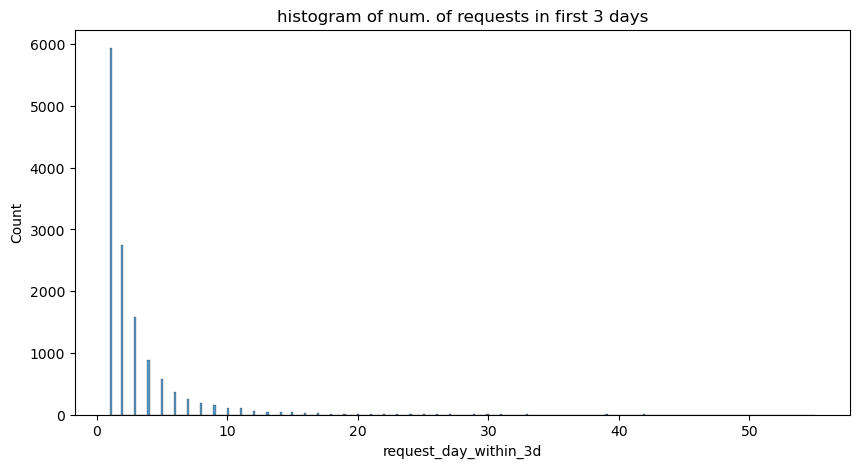

In [129]:
# Show histogram of the number of requests in first 3 days
plt.figure(figsize=(10,5))
sns.histplot(dataset, x="request_day_within_3d")

plt.title('histogram of num. of requests in first 3 days')
plt.show()

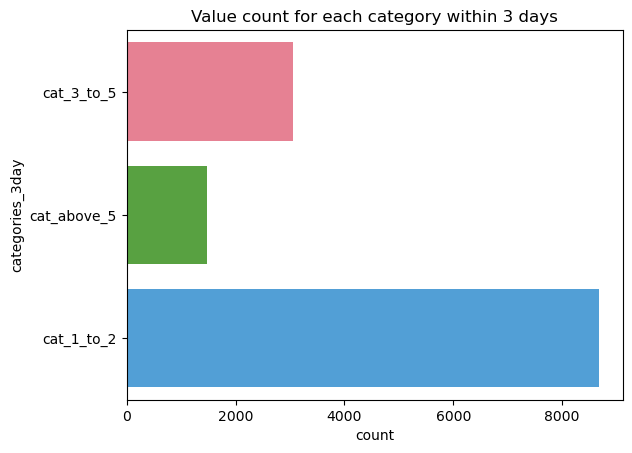

In [149]:
sns.countplot(y=dataset.categories_3day, palette = 'husl')
plt.title('Value count for each category within 3 days')
plt.show()

In [151]:
# Get categorical columns  
df_cat = dataset.select_dtypes(include=['object'])

# Get numeric columns
df_num = dataset.select_dtypes(exclude=['object'])

In [153]:
print("Categorical Columns : \n",list(df_cat.columns) )
print("Numeric Columns : \n",list(df_num.columns) )

Categorical Columns : 
 ['type', 'furnishing', 'lease_type', 'parking', 'building_type', 'categories_7day', 'categories_3day']
Numeric Columns : 
 ['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age', 'property_size', 'swimming_pool', 'rent', 'deposit', 'photo_count', 'request_day_within_7d', 'request_day_within_3d']


In [155]:
df_cat.sample(2)

,type,furnishing,lease_type,parking,building_type,categories_7day,categories_3day
3589,RK1,SEMI_FURNISHED,ANYONE,TWO_WHEELER,IF,cat_above_5,cat_1_to_2
2541,BHK2,SEMI_FURNISHED,FAMILY,TWO_WHEELER,IH,cat_3_to_5,cat_3_to_5


In [157]:
df_num.sample(2)

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_3d
16513,1,1,1.0,0,0,6,600,0,9000,90000,0,1,NaN
4005,1,2,2.0,0,0,4,300,0,4000,40000,7,17,11.0


In [159]:
# Show all values and get count of them in every categorical column
for col in df_cat.columns[:-2]:
    print('Column Name : ', col)
    print(df_cat[col].value_counts())
    print('\n-------------------------------------------------------------\n')

Column Name :  type
type
BHK2        8510
BHK1        4508
BHK3        2691
RK1         1497
BHK4         157
BHK4PLUS      23
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  furnishing
furnishing
SEMI_FURNISHED     13523
NOT_FURNISHED       2917
FULLY_FURNISHED      946
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  lease_type
lease_type
FAMILY      8401
ANYONE      8026
BACHELOR     928
COMPANY       31
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  parking
parking
TWO_WHEELER     8059
BOTH            7771
NONE             921
FOUR_WHEELER     635
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  building_type
building_type
IF    10171
AP     6000
IH     1177
Name: count, dtype: int64

-------------------------------------------------------------



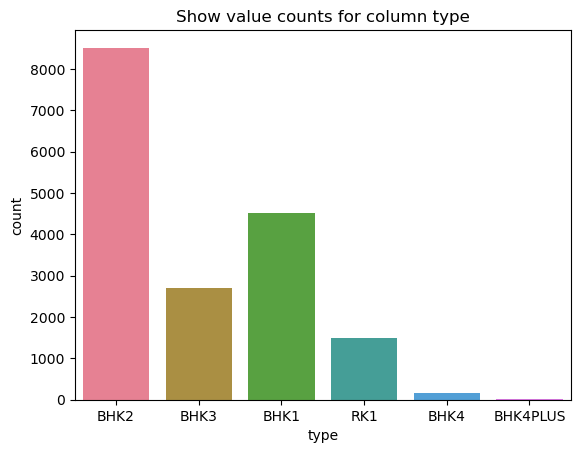

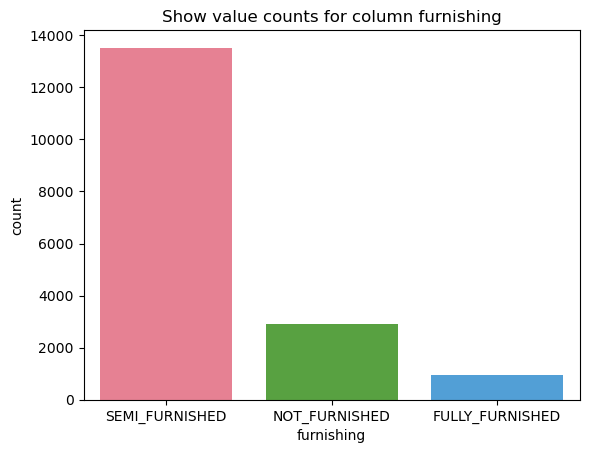

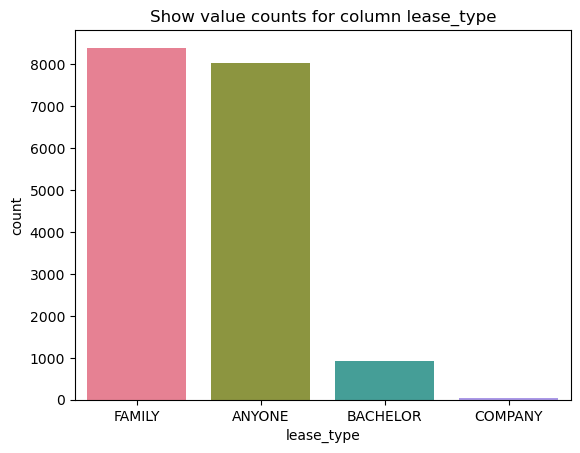

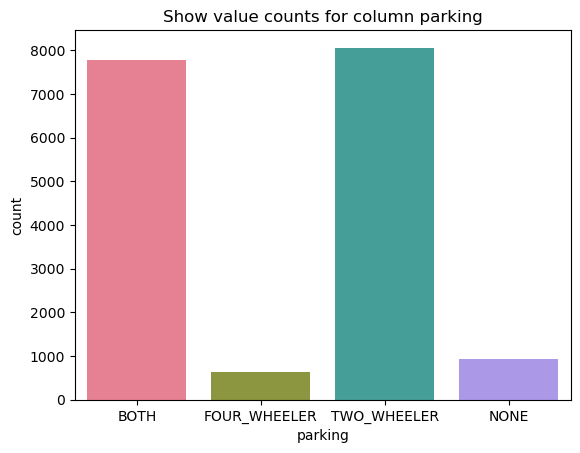

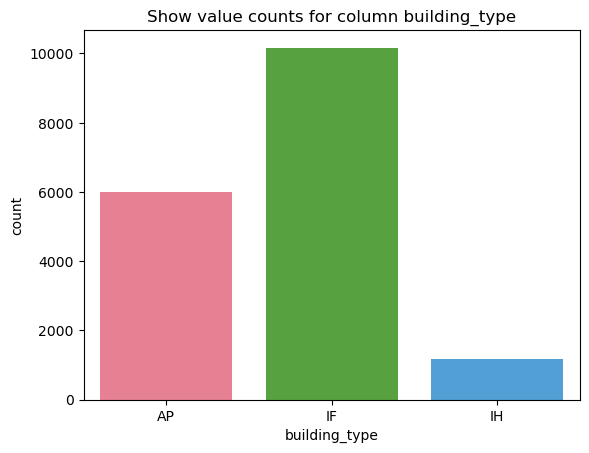

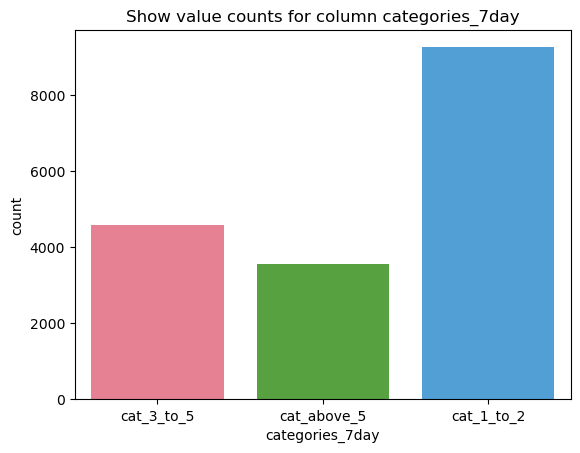

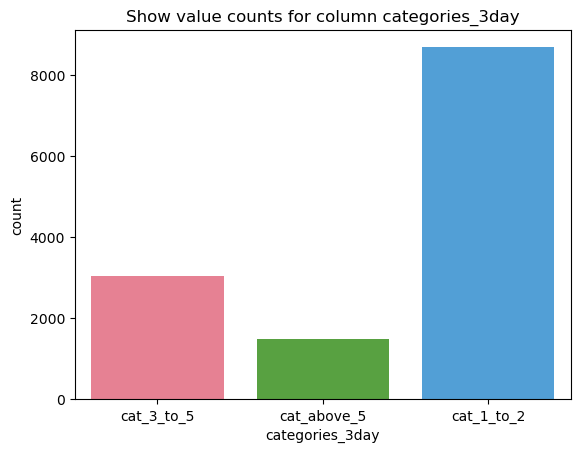

In [165]:
# Plot count of values in every columns 
for col in df_cat.columns:
    sns.countplot(x = col,  
                  
            data = dataset,
                palette = 'husl' )
    plt.title(f'Show value counts for column {col}')
 
    # Show the plot
    plt.show()

In [167]:
df_num.head()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_3d
0,1,3,4.0,1,1,2,850,1,12000,120000,7,4,4.0
1,2,4,11.0,1,1,1,1233,1,20000,150000,0,5,3.0
2,2,0,4.0,1,1,0,1200,0,15000,75000,12,22,15.0
3,2,3,4.0,0,0,1,1300,0,17000,150000,9,7,5.0
4,1,1,2.0,0,0,4,450,0,6500,40000,7,52,25.0


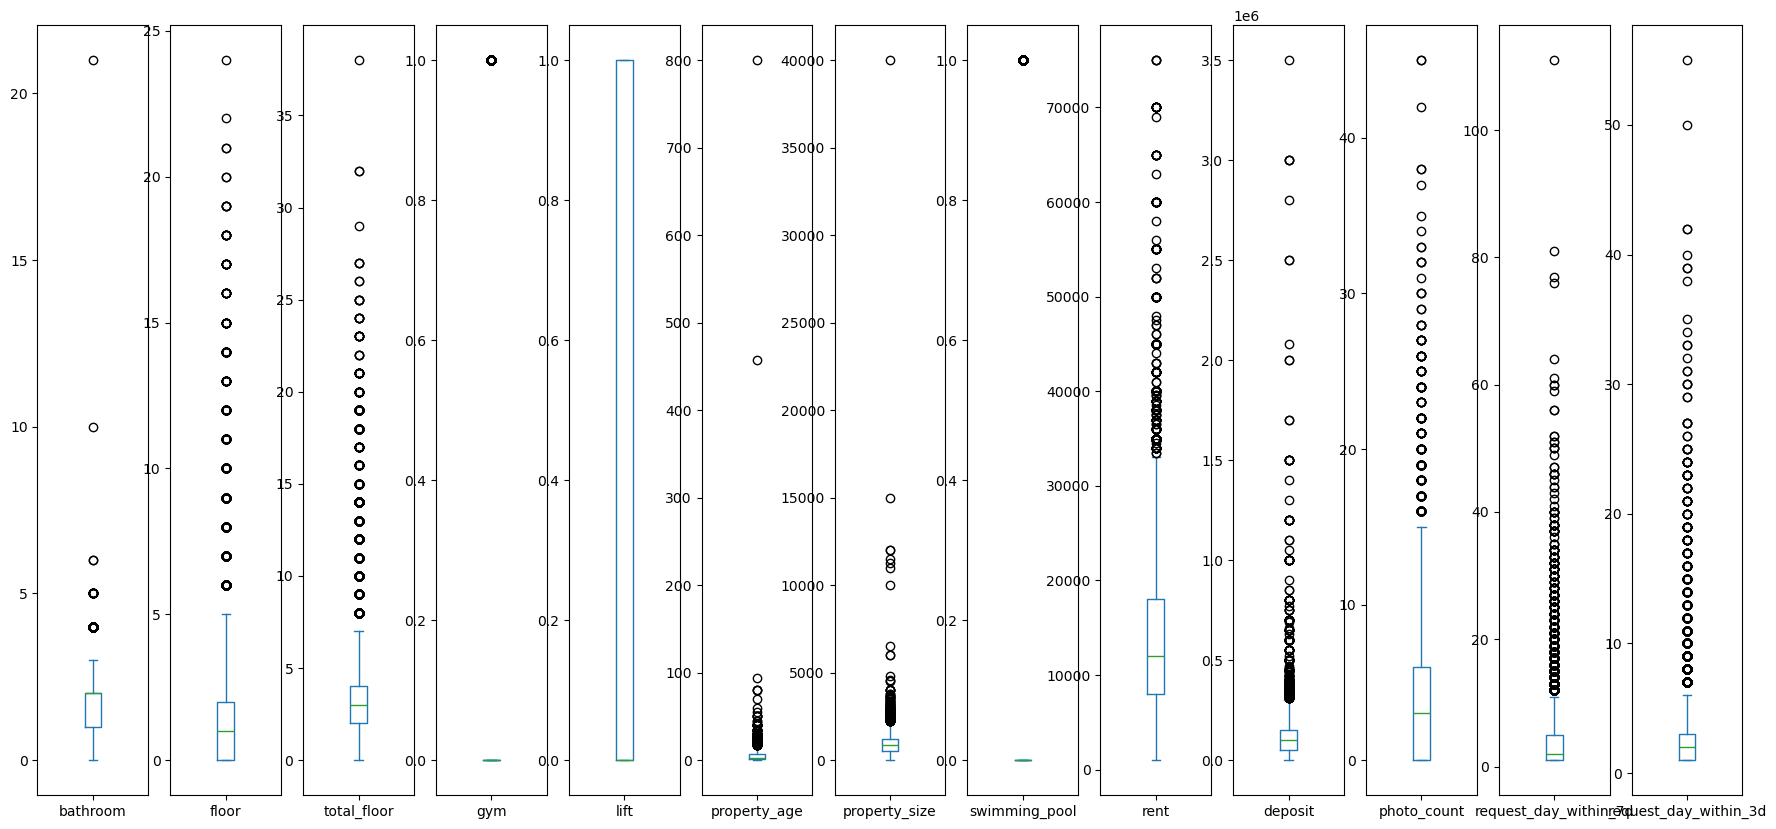

In [169]:
# Box Plot to show ranges of values and outliers
df_num.plot(kind='box', subplots=True,  sharex=False, sharey=False,figsize=(22,10))
plt.show()

In [171]:
# Get some statistics about numeric columns
df_num.describe()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_3d
count,17386.000000,17386.000000,17363.000000,17386.000000,17386.000000,17386.000000,17386.000000,17386.000000,17386.000000,1.738600e+04,17386.000000,17386.000000,13210.000000
mean,1.702692,1.726101,3.382077,0.150063,0.265156,4.789141,912.091510,0.126769,13822.809847,1.145386e+05,3.803635,4.013632,2.802801
std,0.716630,2.041864,3.040158,0.357144,0.441429,8.781275,608.803608,0.332723,8272.442456,1.167101e+05,4.231098,5.050688,3.187711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,1.000000
25%,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,507.000000,0.000000,8000.000000,5.000000e+04,0.000000,1.000000,1.000000
50%,2.000000,1.000000,3.000000,0.000000,0.000000,3.000000,875.000000,0.000000,12000.000000,1.000000e+05,3.000000,2.000000,2.000000
75%,2.000000,2.000000,4.000000,0.000000,1.000000,7.000000,1200.000000,0.000000,18000.000000,1.500000e+05,6.000000,5.000000,3.000000
max,21.000000,24.000000,38.000000,1.000000,1.000000,800.000000,40000.000000,1.000000,75000.000000,3.500000e+06,45.000000,111.000000,55.000000


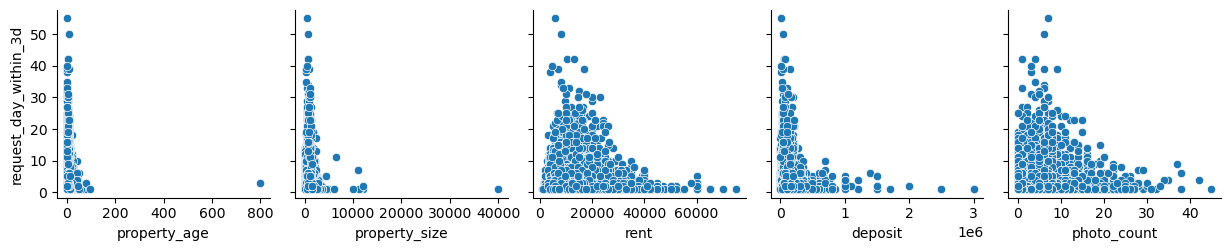

In [181]:
sns.pairplot(data=dataset,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_3d'], palette = 'mako'
             
                  )
plt.show()

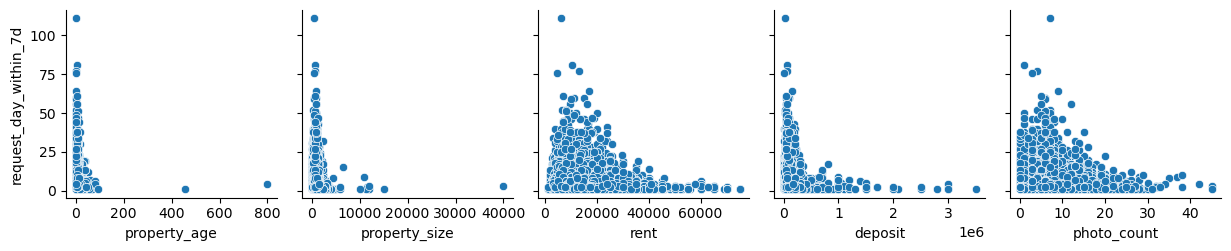

In [183]:
sns.pairplot(data=dataset,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_7d']
             
                  )
plt.show()

### Feature Engineering

In [186]:
# Function to remove outliers using quantiles 
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 #Interquartile range
    fence_low  = q1 - 2 * iqr
    fence_high = q3 + 2 * iqr
    df_out = df_in.loc[(df_in[col_name] <= fence_high) & (df_in[col_name] >= fence_low)]
    return df_out

In [188]:
df_num.columns

Index(['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age',
       'property_size', 'swimming_pool', 'rent', 'deposit', 'photo_count',
       'request_day_within_7d', 'request_day_within_3d'],
      dtype='object')

In [190]:
df = dataset.copy()
for col in df_num.columns:
    if col in ['gym', 'lift', 'swimming_pool',  'request_day_within_3d', 'request_day_within_7d']:
        continue
        
    df = remove_outlier(df , col)
    

In [192]:
def capping_for_3days(x):
    num = 10
    if x > num:
        return num
    else :
        return x
def capping_for_7days(x):
    num = 20
    if x > num:
        return num
    else :
        return x

In [194]:
df['request_day_within_3d_capping'] = df['request_day_within_3d'].apply(capping_for_3days)
df['request_day_within_7d_capping'] = df['request_day_within_7d'].apply(capping_for_7days)

In [196]:
df['request_day_within_3d_capping'].value_counts()

request_day_within_3d_capping
1.0     5115
2.0     2403
3.0     1404
4.0      795
5.0      532
10.0     495
6.0      339
7.0      228
8.0      168
9.0      140
Name: count, dtype: int64

In [198]:
df['request_day_within_7d_capping'].value_counts()[:10]

request_day_within_7d_capping
1     4934
2     2923
3     1848
4     1264
5      937
6      663
7      549
8      330
20     319
9      292
Name: count, dtype: int64

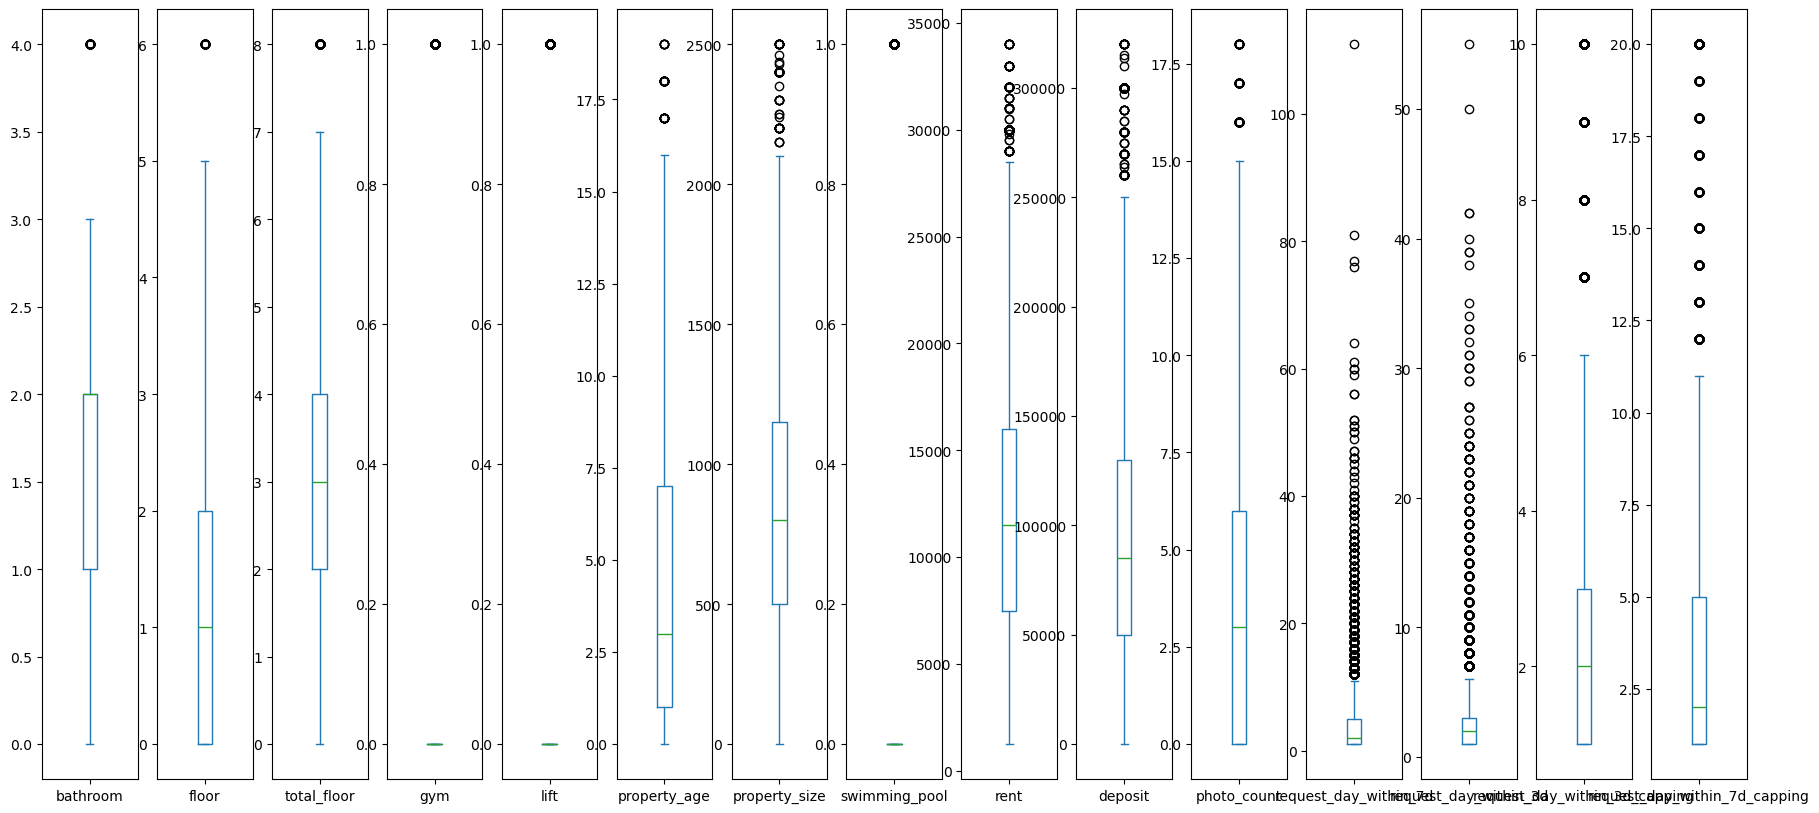

In [200]:
# Box Plot after removing some values
df.plot(kind='box', subplots=True,  sharex=False, sharey=False,figsize=(22,10))
plt.show()

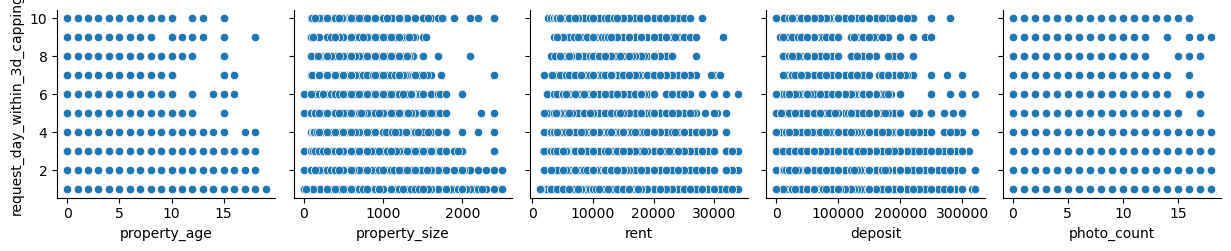

In [202]:
sns.pairplot(data=df,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_3d_capping']
                  )
plt.show()

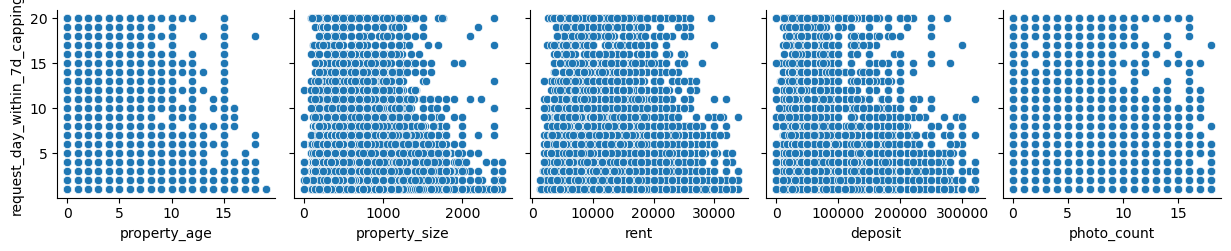

In [204]:
sns.pairplot(data=df,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_7d_capping']
             
                  )
plt.show()

ValueError: could not convert string to float: 'BHK2'

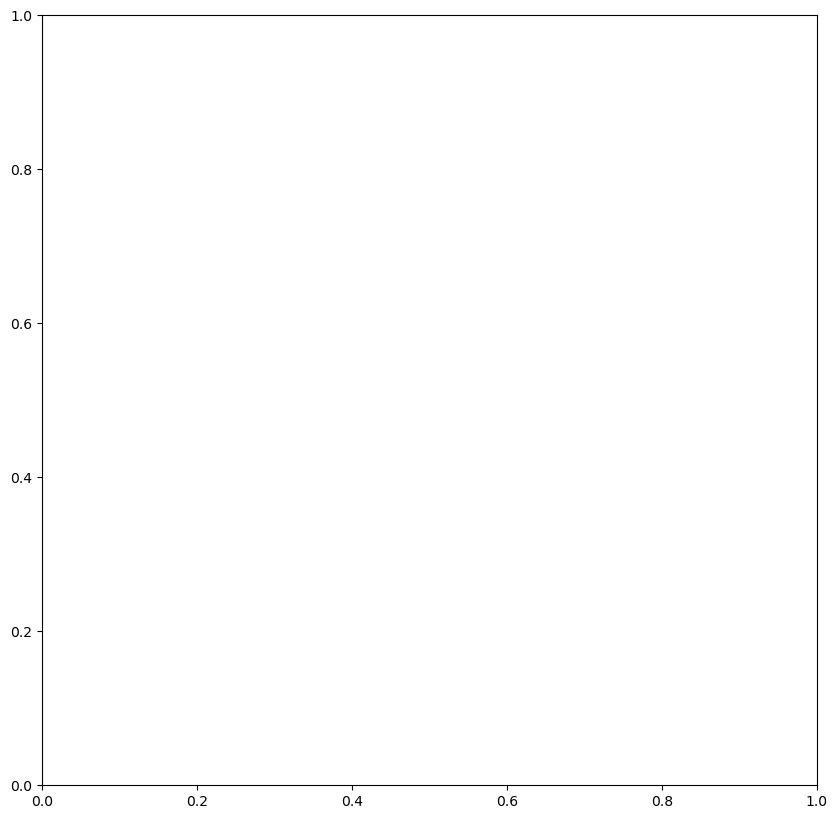

In [206]:
# Show a correlation on a heat map.
plt.subplots(figsize=(10,10))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

In [208]:
df.dtypes 

type                              object
bathroom                           int64
floor                              int64
total_floor                      float64
furnishing                        object
gym                                int64
lease_type                        object
lift                               int64
parking                           object
property_age                       int64
property_size                      int64
swimming_pool                      int64
rent                               int64
deposit                            int64
building_type                     object
photo_count                        int64
request_day_within_7d              int64
categories_7day                   object
request_day_within_3d            float64
categories_3day                   object
request_day_within_3d_capping    float64
request_day_within_7d_capping      int64
dtype: object

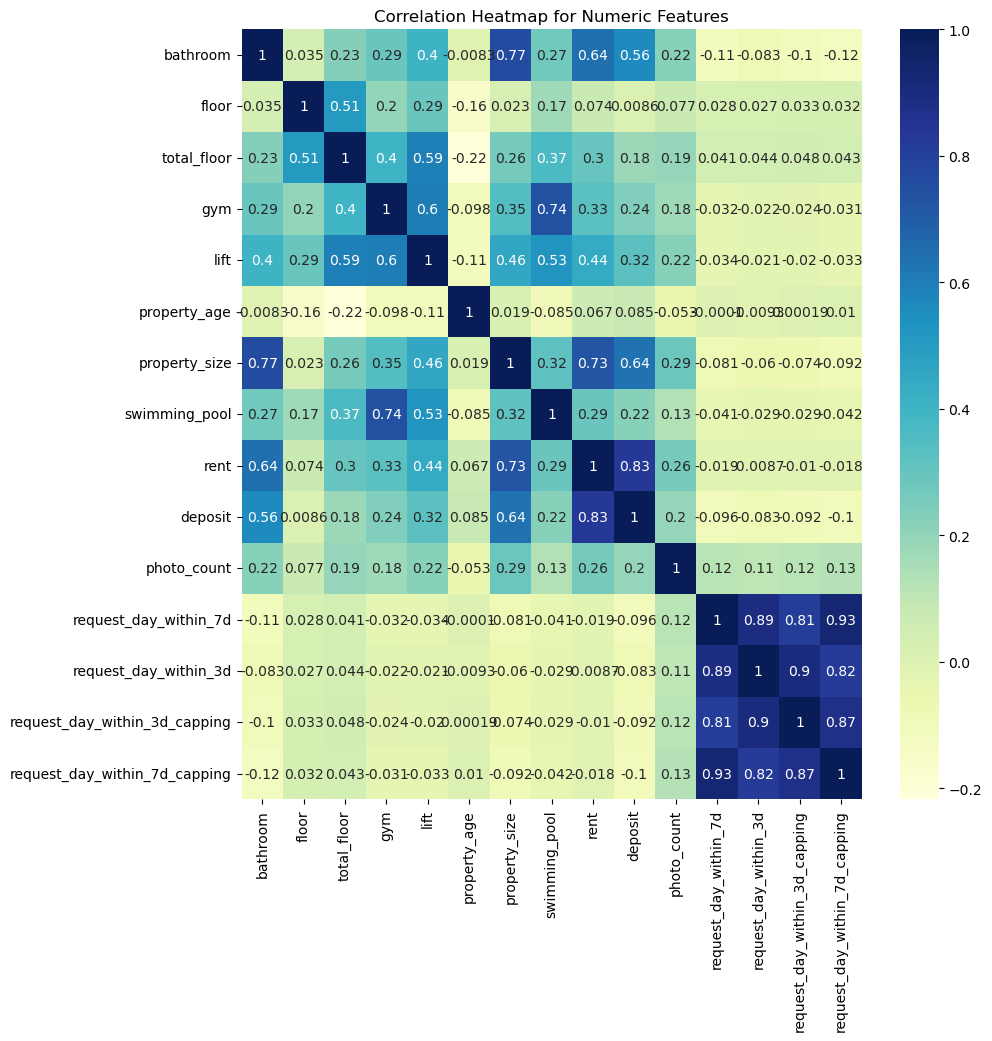

In [210]:
# Filter only numeric columns before calculating the correlation
numeric_df = df.select_dtypes(include=['number'])

# Now plot the heatmap
plt.figure(figsize=(10, 10))
dataplot = sns.heatmap(numeric_df.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()


In [235]:
non_numeric = df.select_dtypes(exclude=['number'])
print(non_numeric.columns)


Index(['type', 'furnishing', 'lease_type', 'parking', 'building_type',
       'categories_7day', 'categories_3day'],
      dtype='object')


### One-Hot Encoding

In [238]:
df.sample(5)

,type,bathroom,floor,total_floor,furnishing,gym,lease_type,lift,parking,property_age,...,rent,deposit,building_type,photo_count,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day,request_day_within_3d_capping,request_day_within_7d_capping
9531,BHK2,2,2,4.0,SEMI_FURNISHED,0,FAMILY,0,TWO_WHEELER,2,...,12700,75000,IF,5,1,cat_1_to_2,1.0,cat_1_to_2,1.0,1
8823,BHK2,2,4,4.0,SEMI_FURNISHED,0,ANYONE,1,BOTH,0,...,20000,180000,AP,0,2,cat_1_to_2,2.0,cat_1_to_2,2.0,2
15587,BHK2,1,3,3.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,4,...,7000,50000,IF,0,2,cat_1_to_2,2.0,cat_1_to_2,2.0,2
13037,BHK1,1,2,3.0,SEMI_FURNISHED,0,FAMILY,1,BOTH,15,...,8500,40000,AP,3,7,cat_above_5,5.0,cat_3_to_5,5.0,7
809,BHK1,1,2,2.0,SEMI_FURNISHED,0,ANYONE,0,TWO_WHEELER,5,...,8000,80000,IF,8,10,cat_above_5,5.0,cat_3_to_5,5.0,10


In [252]:
df.columns

Index(['type', 'bathroom', 'floor', 'total_floor', 'furnishing', 'gym',
       'lease_type', 'lift', 'parking', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'building_type', 'photo_count',
       'request_day_within_7d', 'categories_7day', 'request_day_within_3d',
       'categories_3day', 'request_day_within_3d_capping',
       'request_day_within_7d_capping'],
      dtype='object')

In [254]:
df.dtypes

type                              object
bathroom                           int64
floor                              int64
total_floor                      float64
furnishing                        object
gym                                int64
lease_type                        object
lift                               int64
parking                           object
property_age                       int64
property_size                      int64
swimming_pool                      int64
rent                               int64
deposit                            int64
building_type                     object
photo_count                        int64
request_day_within_7d              int64
categories_7day                   object
request_day_within_3d            float64
categories_3day                   object
request_day_within_3d_capping    float64
request_day_within_7d_capping      int64
dtype: object

In [256]:
df.columns

Index(['type', 'bathroom', 'floor', 'total_floor', 'furnishing', 'gym',
       'lease_type', 'lift', 'parking', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'building_type', 'photo_count',
       'request_day_within_7d', 'categories_7day', 'request_day_within_3d',
       'categories_3day', 'request_day_within_3d_capping',
       'request_day_within_7d_capping'],
      dtype='object')

In [258]:
df.shape

(15170, 22)

In [260]:
# One-Hot Encoder for categorical values
# dividing a data to categorical, numeric and label 

In [263]:
X = df.drop(['request_day_within_7d', 'categories_7day', 'request_day_within_3d',
             'categories_3day', 'request_day_within_3d_capping',
             'request_day_within_7d_capping'] , axis=1)

In [265]:
X.head(2)

,type,bathroom,floor,total_floor,furnishing,gym,lease_type,lift,parking,property_age,property_size,swimming_pool,rent,deposit,building_type,photo_count
0,BHK2,1,3,4.0,SEMI_FURNISHED,1,FAMILY,1,BOTH,2,850,1,12000,120000,AP,7
2,BHK2,2,0,4.0,NOT_FURNISHED,1,ANYONE,1,FOUR_WHEELER,0,1200,0,15000,75000,AP,12


In [267]:
x_cat_withNull= df[X.select_dtypes(include=['O']).columns]

In [269]:
x_cat_withNull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15170 entries, 0 to 17385
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   type           15170 non-null  object
 1   furnishing     15170 non-null  object
 2   lease_type     15170 non-null  object
 3   parking        15170 non-null  object
 4   building_type  15156 non-null  object
dtypes: object(5)
memory usage: 711.1+ KB


In [271]:
x_remain_withNull = df[X.select_dtypes(exclude=['O']).columns]

In [273]:
y = df[['request_day_within_7d', 'categories_7day', 'request_day_within_3d',
             'categories_3day', 'request_day_within_3d_capping',
             'request_day_within_7d_capping']]

In [275]:
x_remain = pd.DataFrame()
x_cat = pd.DataFrame()

In [277]:
# Handling Null values
# if we having null values in a numeric columns fill it with mean (Avg) 

In [281]:
x_remain_withNull.columns

Index(['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age',
       'property_size', 'swimming_pool', 'rent', 'deposit', 'photo_count'],
      dtype='object')

In [283]:
for col in x_remain_withNull.columns:
    x_remain[col] = x_remain_withNull[col].fillna((x_remain_withNull[col].mean()))

In [285]:
x_remain.head(2)

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count
0,1,3,4.0,1,1,2,850,1,12000,120000,7
2,2,0,4.0,1,1,0,1200,0,15000,75000,12


In [287]:
for col in x_cat_withNull.columns:
    x_cat[col] = x_cat_withNull[col].fillna(x_cat_withNull[col].mode()[0])

In [289]:
x_cat.head(2)

,type,furnishing,lease_type,parking,building_type
0,BHK2,SEMI_FURNISHED,FAMILY,BOTH,AP
2,BHK2,NOT_FURNISHED,ANYONE,FOUR_WHEELER,AP


In [291]:
x_remain.isna().sum()

bathroom         0
floor            0
total_floor      0
gym              0
lift             0
property_age     0
property_size    0
swimming_pool    0
rent             0
deposit          0
photo_count      0
dtype: int64

In [293]:
from sklearn.preprocessing import OneHotEncoder

In [295]:
ohe = OneHotEncoder(categories='auto' , handle_unknown='ignore')
feature_train = ohe.fit_transform(x_cat).toarray()
feature_labels = ohe.categories_

In [297]:
new_features = []
for i,j in zip(x_cat.columns,feature_labels):
    new_features.append(f"{i}_"+j)

feature_labels = np.array(new_features, dtype=object).ravel()
f=[]
for i in range(feature_labels.shape[0]):
    f.extend(feature_labels[i])


df_features = pd.DataFrame(feature_train, columns=f)

In [299]:
print(df_features.shape)

(15170, 20)


In [301]:
df_features.sample(3)

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH
12548,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
11091,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### MinMaxScaler

In [304]:
# Scaling
from sklearn.preprocessing import StandardScaler,MinMaxScaler

sc = MinMaxScaler()
x_remain_scaled = sc.fit_transform(x_remain)
x_remain_scaled = pd.DataFrame(x_remain_scaled, columns=x_remain.columns)

In [306]:
y.head(1)

,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day,request_day_within_3d_capping,request_day_within_7d_capping
0,4,cat_3_to_5,4.0,cat_3_to_5,4.0,4


In [308]:
# Concatenate data after applying One-Hot Encoding
data_with_3days = pd.concat([df_features.reset_index(drop=True),x_remain_scaled.reset_index(drop=True), y[['request_day_within_3d',
                                                                                                        'request_day_within_3d_capping',
                                                                                                        'categories_3day']].reset_index(drop=True)], axis=1)

In [310]:
data_with_3days.dropna(inplace=True)
data_with_3days.shape

(11619, 34)

In [312]:
# Concatenate data after applying One-Hot Encoding
data_with_7days = pd.concat([df_features.reset_index(drop=True),x_remain_scaled.reset_index(drop=True), y[['request_day_within_7d',
                                                                                                        'request_day_within_7d_capping',
                                                                                                        'categories_7day']].reset_index(drop=True)], axis=1)

In [314]:
data_with_7days.dropna(inplace=True)

data_with_7days.shape

(15170, 34)

## Classical Machine Learning

### Predicting Interactions Within 3 Days

In [322]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [320]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.4 MB/s eta 0:00:00a 0:00:01


In [324]:
data_with_3days.sample()

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,...,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_3d,request_day_within_3d_capping,categories_3day
12341,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.052632,0.48,0.0,0.328244,0.375,0.388889,1.0,1.0,cat_1_to_2


In [326]:
X = data_with_3days.drop(['request_day_within_3d',
                          'request_day_within_3d_capping',
                          'categories_3day'], axis=1)
y = data_with_3days[['request_day_within_3d', 'request_day_within_3d_capping', 'categories_3day']]

In [328]:
# Split data to train and test sets
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_3d'], test_size = 0.2, random_state = seed)



In [330]:
# Making models with different algorithms 
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model 
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training 
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error 
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    
    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (3.304326)
LASSO: RMS => (3.409854)
KNN: RMS => (3.568612)
CART: RMS => (4.914348)
xgb: RMS => (3.463343)


##### Based on the results, linear regression has less RMS (root mean square) so he is the best. In the next step, we will try some improvements.

##### Second Iteration with capping target column

In [334]:
# Split data to train and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_3d_capping'], test_size = 0.2, random_state = seed)

# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model 
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training 
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error 
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    
    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (2.277916)
LASSO: RMS => (2.380321)
KNN: RMS => (2.472854)
CART: RMS => (3.181372)
xgb: RMS => (2.348409)


As a result of this iteration, the result is better, and the best model is still linear regression because it has a lower RMS

##### Third Iteration with Classification

In [338]:
seed = 42
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y['categories_3day'], test_size = 0.2, random_state = seed)

In [340]:
y['categories_3day'].value_counts()

categories_3day
cat_1_to_2     7518
cat_3_to_5     2731
cat_above_5    1370
Name: count, dtype: int64

In [342]:
# Logistic Regression
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr_pro = lr.predict_proba(X_test)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

  cat_1_to_2       0.65      0.99      0.79      1511
  cat_3_to_5       0.29      0.01      0.01       528
 cat_above_5       0.52      0.04      0.07       285

    accuracy                           0.65      2324
   macro avg       0.49      0.35      0.29      2324
weighted avg       0.55      0.65      0.52      2324



data is unbalanced 

In [345]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced',random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc_pro = rfc.predict_proba(X_test)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc)  )

              precision    recall  f1-score   support

  cat_1_to_2       0.66      0.89      0.76      1511
  cat_3_to_5       0.27      0.12      0.16       528
 cat_above_5       0.31      0.08      0.12       285

    accuracy                           0.61      2324
   macro avg       0.41      0.36      0.35      2324
weighted avg       0.53      0.61      0.55      2324



Based on the results, we can find that the f1-score is 62% and that result is not bad it's better than logistic regression.

### Predicting Interactions Within 7 Days

In [350]:
data_with_7days.sample()

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,...,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_7d_capping,categories_7day
12498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.263158,0.48,0.0,0.419847,0.265625,0.222222,18,18,cat_above_5


In [352]:
X = data_with_7days.drop(['request_day_within_7d',
                          'request_day_within_7d_capping',
                          'categories_7day'], axis=1)
y = data_with_7days[['request_day_within_7d', 'request_day_within_7d_capping', 'categories_7day']]

In [359]:
#FIRST ITERATION

# Split data to train and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_7d'], test_size = 0.2, random_state = seed)


# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model 
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training 
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error 
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    
    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (5.243629)
LASSO: RMS => (5.459693)
KNN: RMS => (5.596178)
CART: RMS => (7.160084)
xgb: RMS => (5.353307)


Based on the results, linear regression has less RMS (root mean square) so he is the best. In the next step, we will try some improvements.

In [362]:
#SECOND ITERATION

# Split data to train and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_7d_capping'], test_size = 0.2, random_state = seed)

# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model 
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training 
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error 
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    
    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (4.044747)
LASSO: RMS => (4.249220)
KNN: RMS => (4.319646)
CART: RMS => (5.797303)
xgb: RMS => (4.130722)


As a result of this iteration, the result is better, and the best model is still linear regression because it has a lower RMS

In [365]:
#Third Iteration with Classification
seed = 42
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y['categories_7day'], test_size = 0.2, random_state = seed)

# Logistic Regression
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr_pro = lr.predict_proba(X_test)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

  cat_1_to_2       0.55      0.91      0.68      1570
  cat_3_to_5       0.23      0.01      0.03       794
 cat_above_5       0.42      0.22      0.29       670

    accuracy                           0.53      3034
   macro avg       0.40      0.38      0.33      3034
weighted avg       0.44      0.53      0.42      3034



In [367]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced',random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc_pro = rfc.predict_proba(X_test)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc)  )

              precision    recall  f1-score   support

  cat_1_to_2       0.57      0.76      0.65      1570
  cat_3_to_5       0.28      0.18      0.21       794
 cat_above_5       0.39      0.26      0.31       670

    accuracy                           0.49      3034
   macro avg       0.41      0.40      0.39      3034
weighted avg       0.45      0.49      0.46      3034



Based on the results, classification is a bad choice here.

## Deep Learning

In [371]:
X = data_with_3days.drop(['request_day_within_3d',
                          'request_day_within_3d_capping',
                          'categories_3day'], axis=1)
y = data_with_3days[['request_day_within_3d', 'request_day_within_3d_capping', 'categories_3day']]

In [373]:
seed = 42
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_3d_capping'], test_size = 0.2, random_state = seed)

In [379]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout

# Create ANN model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(X_train, y_train, epochs=50)

ModuleNotFoundError: No module named 'tensorflow'

In [377]:
!pip install keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 5.9 MB/s eta 0:00:00


In [381]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 4.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 5.2 MB/s eta 0:00:00a 0:00:01
